![image.png](https://user.oc-static.com/upload/2019/10/22/15717382019055_Capture%20d%E2%80%99e%CC%81cran%202019-10-22%20a%CC%80%2011.50.29.png)

**Air Paradis** est une compagnie aérienne qui souhaite utiliser l'IA (*Intelligence Artificielle*) pour **détecter les Bad Buzz associés à sa marque** dans les tweets publics en ligne.

**En tant qu'ingénieur AI pour Marketing Intelligence Consulting**, nous allons nous plonger dans les techniques de **NLP** (*Natural Language Processing*) pour servir l'objectif d'Air Paradis.

En effet, le NLP permet à une machine de **comprendre et de traiter le langage humain**. Il nous aidera à résoudre cet **objectif de classification de texte** et à **détecter le sentiment** (positif ou négatif) de ces tweets.

Nous allons déployer notre meilleure solution **DETECT SENTIMENT** à travers la plateforme **Microsoft Azure Machine Learning** (***MS Azure ML***).

# Import des librairies et chargement des données

In [1]:
import dateutil, datetime

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import re
import contractions

import nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')

from wordcloud import WordCloud, STOPWORDS

import pycld2 as cld2

import spacy
import en_core_web_sm
nlp = spacy.load('en_core_web_sm', disable=['parser'])

from collections import Counter

[nltk_data] Downloading package stopwords to /home/reda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Le projet ne fournis pas de donnée nous allons donc en récupéré via ce lien https://www.kaggle.com/datasets/kazanova/sentiment140.

- convertir la chaîne PDT (fuseau horaire US/Pacifique).

Voici les différentes colonnes de notre ressource :

- **target**: la polarité du tweet (0 = négatif, 2 = neutre, 4 = positif. Mais nous n'avons pas de sentiement = 2 dans notre jeux de données)

- **ids**: l'identifiant du tweet

- **date**: la date du tweet

- **flag**: la requête. S'il n'y a pas de requête, cette valeur est NO_QUERY.

- **user**: l'utilisateur qui a tweeté

- **text**: le texte du tweet

In [2]:
df = pd.read_csv('data/training.1600000.processed.noemoticon.csv',
                 encoding = 'ISO-8859-1',
                 # Nous précison le nom de chaque colonne car elles n'ont 
                 # pas d'en tête'
                 names=['sentiment', 'id', 'date', 'flag', 'user', 'tweet'])

# Supprime la colonne flag qui nous pensons ne sera pas utile
del df["flag"]

In [3]:
# df = df.sample(50000)

In [4]:
df.head(2)

,sentiment,id,date,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...


# Selection des données

Les tweet négatifs ont pour valeur "0" et "4" pour les tweets positifs.

Remplaçons ces valeurs pour les rendre un peu plus claires :

- 0 pour les tweets négatifs 

- 1 pour les tweets positifs.

In [5]:
df['sentiment'] = df['sentiment'].replace([0, 4],[0,1])

df.sentiment.value_counts()

0    800000
1    800000
Name: sentiment, dtype: int64

La target est plutôt equilibrée pour le moment.

# Premier nettoyage

Nous savons que les tweet on été envoyés du 6 mai 2009 au 25 juin 2009. Nous pouvons supprimer la colonne date qui ne sera surement pas très utile.

In [6]:
del df['date']

Passons au valeurs manquantes.

In [7]:
df.isnull().values.any()

False

Nous n'avons aucune valeur manquante pour le moment. Passons aux doublons

In [8]:
df[df.duplicated(subset=['user', 'tweet'])].sort_values("user")

,sentiment,id,user,tweet
999959,1,1879941003,007peter,"@NaniWaialeale No, not Keith Olbermann, he ann..."
995446,1,1835719548,007wisdom,'Time Is An Illusion and All Time Is Now'... &...
889033,1,1687496734,007wisdom,&quot;All that we are is the result of what we...
984036,1,1834348688,007wisdom,'Time Is An Illusion and All Time Is Now'... &...
953751,1,1824711167,007wisdom,'Time Is An Illusion and All Time Is Now'... &...
...,...,...,...,...
1579667,1,2189971294,zibbet,Learn how to 'Effectively Promote Your Shop' u...
1185965,1,1982872880,zoetunstall,@tommcfly Hey Tom whereabouts in Uganda did y...
942791,1,1794782830,zoezf,@enzopilarta kakaasar kasi eh! puro cliffhange...
1591551,1,2191582417,zombieite,packing :-| :-/ :-?


Seul les doublons sur les tweets sont vraiment important. Mais nous devons supprimer les doublons de tweet lorsqu'ils appartiennent au même utilisateur, pour ne pase supprimer deux même tweet que deux personnes auraient postés

In [9]:
df.drop_duplicates(subset=['user', 'tweet'], inplace=True)
df[df.duplicated(subset=['user', 'tweet'])].sort_values("user")

,sentiment,id,user,tweet


# Preprocessing

Dans cette section, nous allons créer une série de fonctions de prétraitement, pour nettoyer les tweets et les rendre plus lisibles.

Nous allons effectuer les étapes suivantes :

- Normaliser le texte en minuscules ;
- Corriger certaines fautes d'orthographe que nous avons détectées ;
- Supprimer (ou remplacer) toutes les mentions d'utilisateurs, urls, hyperliens, emails et hashtags ;
- Supprimer (ou remplacer) certains caractères spécifiques ;
- Développer toutes les contractions anglaises pour conserver le sens et notamment le mot " not " qui pourrait être essentiel pour détecter un sentiment négatif ;
- Supprimer les chiffres et les caractères spéciaux ;
- Supprimer les ponctuations ;
- Supprimer les espaces blancs.
- La suppression des stopwords
- La lemmatisation 

Nous allons séparer les tweets de bases et les tweets traités.

In [10]:
df['tweet_traite'] = df['tweet'].copy()

df.head()

,sentiment,id,user,tweet,tweet_traite
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all....","@nationwideclass no, it's not behaving at all...."


#### Preproccessing general (stopwords, regex, lemmatisation...)

In [11]:
# Le tokenizer prends en compte les hashtag et les emojis dans la séparation
# des caractères
tknzr = TweetTokenizer()

def contraction(tweet):
    """
    Les contractions en anglais sont les "I'm" pour "I am", "It's" pour
    "It is". Nous allons donc remplacer les contractions pour avoir le 
    pronom et le verbe bien distinct
    """
    tweet = contractions.fix(tweet)
    return tweet

def traitement_tweet(tweet):
    """
    Cette fonction permet le traitement des textes de toutes la colonne
    sans boucle sur la dataframe.
    
    case=True/False --> sensibilité au majuscule et minuscule
    """
    # Convertis le tweet en minuscules
    tweet = tweet.str.lower()

    # Suppression des caractères échappés de Twitter (guillemets, esperluettes,
    # acronymes, émoticônes...)
    tweet = tweet.str.replace('&quot|&amp;|&gt;|&lt;', '')

    # Supprimer les URLs standards (commençant par http, https ou www)
    tweet = tweet.str.replace(r'http\S+|https\S+| www.\S+', 'url', case=False)

    # Supprimez les autres hyperliens (se terminant par .com, .org ou .net).
    tweet = tweet.str.replace(r'\S+\.com|\S+\.org|\S+\.net', 'url', case=False)

    # Remplacer toutes les mentions @ par users et # par hashtags
    tweet = tweet.str.replace(r'@[\w]*', 'user', case=False)
    tweet = tweet.str.replace(r'\#+[\w_]+[\w\'_\-]*[\w_]+', 'hashtag')

    # Supprime les réaction qui ne sont pas dans le dictionnaire
    tweet = tweet.str.replace(
        'lol|oh |haha|blah|ahh|aww|wow|yeah|yay|hmm|wtf|grr', '')
    
    # Replace "-" et " ' " par un espace
    tweet = tweet.str.replace("-|'", ' ')
    
    # Supprime tous les caractères numériques et spécial
    tweet = tweet.str.replace(r'[^a-zA-Z\s]', ' ')
    
    # Supprime la ponctuation
    tweet = tweet.str.replace(r'[^\w\s]+', '')
    
    # Nous allons supprimer renommer les mot en abrégés.
    # Les espaces sont là pour évité de modifier la lettre dans un mot
    # exemple : pour 'u : 'you' alors 'user' va devenir 'youser'
    dict_abrege = {
        'omg': 'god',
        'gosh': 'god',
        'its': 'it is',
        'idk': 'i do not know',
        'your welcome': 'you are welcome',
        'bday': 'birthday',
        ' ur ': ' your ',
        ' til ': ' until ',
        'shoulda': 'should',
        'fb': 'facebook',
        'thx': 'thanks',
        ' yur ': ' your ',
        ' u ': ' you '
    }

    # Corrige les mot en abrégé
    for key in dict_abrege.keys():
        tweet = tweet.str.replace(key, dict_abrege[key], case=True)

    return tweet

In [12]:
# Initisalisation du stopwords
stop_words = stopwords.words('english')
stop_words.extend(["could", "might", "should", "us", "would",
                   "bit", "from", "re"])

# Nous ne voulons pas que ces deux mots soient supprimés, ils peuvent
# donner une indication sur le caractère positif ou négatif du tweet
stop_words.remove("not")
stop_words.remove("no")

print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very',

In [13]:
def supprimer_stopwords(tweet):

    tweet = tweet.apply(lambda x: ' '.join(
        [mot for mot in x.split() if mot not in (stop_words)]))

    return tweet


def lemmatisation(tweet):
    doc = nlp(tweet)
    tweet = " ".join([token.lemma_ for token in doc])

    return tweet


def supprime_lettre_seul(df, colonne):
    df[colonne] = df[colonne].str.replace(r'\b\w\b',
                                          '').str.replace(r'\s+', ' ')
    return df

In [14]:
df['tweet_traite'] = df['tweet_traite'].apply(contraction)
df['tweet_traite'] = traitement_tweet(df['tweet_traite'])
df['tweet_traite'] = supprimer_stopwords(df['tweet_traite'])

/tmp/ipykernel_10213/3665271016.py:26: FutureWarning: The default value of regex will change from True to False in a future version.
  tweet = tweet.str.replace('&quot|&amp;|&gt;|&lt;', '')
/tmp/ipykernel_10213/3665271016.py:29: FutureWarning: The default value of regex will change from True to False in a future version.
  tweet = tweet.str.replace(r'http\S+|https\S+| www.\S+', 'url', case=False)
/tmp/ipykernel_10213/3665271016.py:32: FutureWarning: The default value of regex will change from True to False in a future version.
  tweet = tweet.str.replace(r'\S+\.com|\S+\.org|\S+\.net', 'url', case=False)
/tmp/ipykernel_10213/3665271016.py:35: FutureWarning: The default value of regex will change from True to False in a future version.
  tweet = tweet.str.replace(r'@[\w]*', 'user', case=False)
/tmp/ipykernel_10213/3665271016.py:36: FutureWarning: The default value of regex will change from True to False in a future version.
  tweet = tweet.str.replace(r'\#+[\w_]+[\w\'_\-]*[\w_]+', 'hasht

In [15]:
%%time
# # Lemmatise les tweets de la colonne 'tweet_pas_stopwords' dans une nouvelle colonne
df["tweet_traite"] = df['tweet_traite'].apply(lambda x: lemmatisation(x))

CPU times: user 1h 26min 41s, sys: 526 ms, total: 1h 26min 42s
Wall time: 1h 26min 41s


L'execution de la précédente cellule étant très longue (1h10), nous allons exporter la dataframe sous csv et réduire le temps d'execution du notebook pour le développement.

Le fichier csv aura donc l'étape de la lemmatisation que nous n'aurons plus besoin de faire.

In [16]:
df.to_csv("data/df_preprocessing_reduit.csv",index=False)
# df = pd.read_csv("data/df_preprocessing_reduit.csv")

Au vu du traitement que nous avions fait sur les tweets, il est normal que des tweets ne se retrouve plus dans la colonne des tweets traités.

#### Supprime les lettres seules

In [17]:
# Nous supprimons maintenant les lettres seules du tweet
df = supprime_lettre_seul(df, "tweet_traite")

/tmp/ipykernel_10213/3579419154.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  df[colonne] = df[colonne].str.replace(r'\b\w\b',


#### Exclusion des tweets ayant qu'un seul mot

Nous allons maintenant garder seulement les tweet ayant plus d'un mot.

In [18]:
df['nombre_mot'] = df['tweet_traite'].str.split().str.len()

In [19]:
x = df.shape[0]
df = df[(df.nombre_mot > 1)]
y = df.shape[0]
suppression_ligne = x-y
print('{} ligne(s) on été supprimée(s)'.format(suppression_ligne))
df.head()

25295 ligne(s) on été supprimée(s)


,sentiment,id,user,tweet,tweet_traite,nombre_mot
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",user url bummer get david carr third day,8
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,upset can not update facebook texting cry resu...,11
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,user dive many time ball manage save rest go b...,10
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,whole body feel itchy like fire,6
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all....",user no not behave mad can not see,8


Nous allons supprimer les nouveaux doublons.

#### Suppression des doublons

In [20]:
x = df.shape[0]
df.drop_duplicates(subset=['user', 'tweet_traite'], inplace=True)
y = df.shape[0]
suppression_ligne = x-y
print('{} ligne(s) on été supprimée(s)'.format(suppression_ligne))
df.head()

8817 ligne(s) on été supprimée(s)


,sentiment,id,user,tweet,tweet_traite,nombre_mot
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",user url bummer get david carr third day,8
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,upset can not update facebook texting cry resu...,11
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,user dive many time ball manage save rest go b...,10
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,whole body feel itchy like fire,6
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all....",user no not behave mad can not see,8


#### Suppression des tweets non anglais

Essayons de supprimer les tweets qui ne sont pas en anglais.

In [21]:
%%time
df['langue'] = df['tweet_traite'].apply(cld2.detect)

CPU times: user 7.67 s, sys: 700 ms, total: 8.37 s
Wall time: 8.39 s


In [22]:
# Ne garde que la langue parmis toutes les informations du dictionnaire
def test_language(langue):
    texte = langue[2][0][0]
    return texte

In [23]:
%%time
df['langue'] = df['langue'].apply(test_language)

CPU times: user 596 ms, sys: 0 ns, total: 596 ms
Wall time: 594 ms


In [24]:
df.head(10)

,sentiment,id,user,tweet,tweet_traite,nombre_mot,langue
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",user url bummer get david carr third day,8,ENGLISH
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,upset can not update facebook texting cry resu...,11,ENGLISH
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,user dive many time ball manage save rest go b...,10,ENGLISH
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,whole body feel itchy like fire,6,ENGLISH
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all....",user no not behave mad can not see,8,ENGLISH
5,0,1467811372,joy_wolf,@Kwesidei not the whole crew,user not whole crew,4,ENGLISH
6,0,1467811592,mybirch,Need a hug,need hug,2,Unknown
7,0,1467811594,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...,user hey long time no see yes rain fine thank,10,ENGLISH
8,0,1467811795,2Hood4Hollywood,@Tatiana_K nope they didn't have it,user nope not,3,ENGLISH
9,0,1467812025,mimismo,@twittera que me muera ?,user que muera,3,Unknown


In [25]:
df[df["langue"] == "Unknown"]

,sentiment,id,user,tweet,tweet_traite,nombre_mot,langue
6,0,1467811592,mybirch,Need a hug,need hug,2,Unknown
9,0,1467812025,mimismo,@twittera que me muera ?,user que muera,3,Unknown
11,0,1467812579,pardonlauren,I just re-pierced my ears,pierced ear,2,Unknown
17,0,1467813137,armotley,about to file taxes,file taxis,2,Unknown
28,0,1467815199,abel209,ooooh.... LOL that leslie.... and ok I won't ...,ooooh leslie ok not leslie not get mad,8,Unknown
...,...,...,...,...,...,...,...
1599942,1,2193576832,martybaltiero,is now a dsc student. http://twitpic.com/7jp4d,dsc student url,3,Unknown
1599945,1,2193577154,kcnitt,"oh yes, and btw, 8.00",yes way,2,Unknown
1599967,1,2193578138,paligurl93,checking my mail,check mail,2,Unknown
1599985,1,2193578982,LISKFEST,"if ur the lead singer in a band, beware fallin...",lead singer band beware fall prey lsd lead sin...,13,Unknown


Les langues non déctécter ont souvent l'air d'être de l'anglais, nous allons donc les remplacer par cette langue.

In [26]:
%%time
df["langue"] = df["langue"].replace('Unknown', 'ENGLISH')

CPU times: user 228 ms, sys: 40 ms, total: 268 ms
Wall time: 265 ms


In [27]:
df[df["langue"] != "ENGLISH"].head(50)

,sentiment,id,user,tweet,tweet_traite,nombre_mot,langue
236,0,1467872594,MalloryLe,is in the bathroom... wake up lakin.,bathroom wake lakin,3,AZERBAIJANI
353,0,1467900033,edlimagno,@ScoutBuck tons no hay Troll? ahhhh,user ton no hay troll hh,6,SPANISH
904,0,1468035296,YoungFlame,C'mon sean man,mon sean man,3,SESELWA
1213,0,1468108602,soundslikechaos,"I have chapped lips, boo",chap lip boo,3,SCOTS
1342,0,1468133099,mrtux_hdb,Chi?u nay h?p chu?n b? t? ch?c m?y s? ki?n ? t...,chi nay chu ch ki tr ng bao nhi vi,10,VIETNAMESE
1700,0,1468212382,Colsi,I need SIMS 3. Gaah!,need sim gaah,3,PORTUGUESE
1806,0,1468237946,e11ena,@vomitto ahh ai dreptate Pixar,user ai dreptate pixar,4,PORTUGUESE
1837,0,1468245086,ahyng,Bored from doing homework What is pingping do...,bored homework pingping,3,SUNDANESE
1909,0,1468260638,unicornanatomy,@djginaturner no le gusta house of house 5 min...,user no le gusta house house min intro,8,SPANISH
1927,0,1468264062,ChrisScherer,Im such an insomniac this week,insomniac week,2,SLOVAK


Certain tweet sont en anglais mais mal orthographié, il leurs sont donc attribué une autre langue.

Nous allons donc garder les tweets en anglais seulement.

In [28]:
df = df[(df["langue"] == "ENGLISH")]

In [29]:
del df["langue"]

#### Equilibrage de la target

Et enfin, nous allons réequilibrer la target si besoin.

In [30]:
df.sentiment.value_counts()

0    775821
1    772887
Name: sentiment, dtype: int64

In [31]:
def equilibrage_target(df, colonne):
    negatif = df[colonne].value_counts()[0]
    positif = df[colonne].value_counts()[1]
    if negatif > positif:
        # Sentiment positif moins sentiment négatifs
        difference = negatif - positif
        # Prends des lignes négatives aléatoirement
        df_sentiment = df[df[colonne] == 0].sample(difference)
        liste_sentiment = list(df_sentiment.index)
        # Réaffecte la dataframme sans les lignes choisies aléatoirement
        df = df[~df.index.isin(liste_sentiment)]
        print(df[colonne].value_counts())
    elif positif > negatif:
        difference = positif - negatif
        # Prends des lignes positives aléatoirement
        df_sentiment = df[df[colonne] == 1].sample(difference)
        liste_sentiment = list(df_sentiment.index)
        df = df[~df.index.isin(liste_sentiment)]
        print(df[colonne].value_counts())
    return df

In [32]:
df = equilibrage_target(df, 'sentiment')

0    772887
1    772887
Name: sentiment, dtype: int64


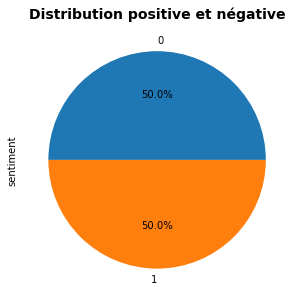

0    772887
1    772887
Name: sentiment, dtype: int64


In [33]:
# Trace la dictribution des tweets négatifs et positifs
plt.figure(figsize=(8,5))

df['sentiment'].value_counts().plot(kind='pie',
                                 # Chiffre après la virgule
                                 autopct='%1.1f%%')
plt.title('Distribution positive et négative',
          fontsize=14, fontweight='bold')
plt.show()

print(df["sentiment"].value_counts())

# Visualisation

## Wordcloud

### Avec premier nettoyage

In [34]:
mot_negatif = df[df.sentiment == 0]
mot_positif = df[df.sentiment == 1]

In [35]:
def wordcloud(df, colonne):

    tous_tweet = str(df[colonne].values)
    tweet_negatif = str(mot_negatif[colonne].values)
    tweet_positif = str(mot_positif[colonne].values)

    # Instanciation de WordCloud
    wc_tous = WordCloud(width=600, height=600, background_color="white",
                       max_words=200, stopwords=STOPWORDS, max_font_size=90,
                       collocations=False, random_state=42).generate(tous_tweet)

    wc_negatif = WordCloud(width=600, height=600, background_color="white",
                       max_words=200, stopwords=STOPWORDS, max_font_size=90,
                       collocations=False, random_state=42).generate(tweet_negatif)

    wc_positif = WordCloud(width=600, height=600, background_color="white",
                       max_words=200, stopwords=STOPWORDS, max_font_size=90,
                       collocations=False, random_state=42).generate(tweet_positif)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    ax1.imshow(wc_tous, interpolation='bilinear')
    ax1.set_title('Tous les tweets', fontsize=12, fontweight='bold')
    ax1.axis('off')

    ax2.imshow(wc_negatif, interpolation='bilinear')
    ax2.set_title('Tweets négatifs', fontsize=12, fontweight='bold')
    ax2.axis('off')

    ax3.imshow(wc_positif, interpolation='bilinear')
    ax3.set_title('Tweets positifs', fontsize=12, fontweight='bold')
    ax3.axis('off')

    plt.suptitle('Tweets Word Clouds', fontsize=16, fontweight='bold')
    plt.show()

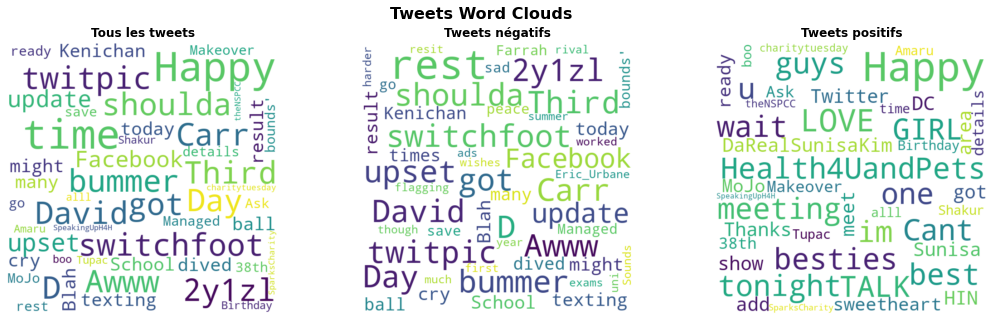

In [36]:
wordcloud(df, "tweet")

### Avec preprocessing

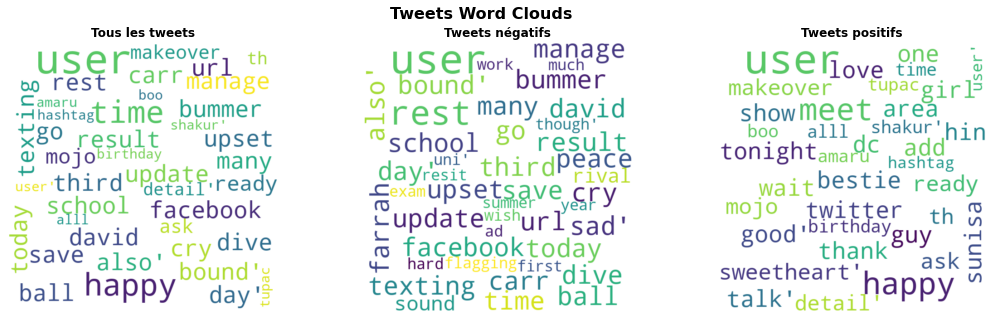

In [37]:
wordcloud(df, "tweet_traite")

## Frequence

#### Avec premier nettoyage

Nous allons maintenant regarder la fréquence de chaque mot pour les tweets avec le premier traitement, et avec les tweets traités avec la suppression des stopwrods, la lemmatisation etc.

In [38]:
def frequence(df, colonne):
    # Créer une liste vide de chaînes de caractères
    mots = ''

    # Place chaque mot de chaque tweet dans la liste "mots"
    for i in df[colonne].values:
        mots += i
    print('Nombre de mots', len(mots))

    # 'mots.split()' split chaque mot de la chaine de caractère.
    # 'most_common(50)'' récupère les 50 mots les plus courant
    mots_frequence = pd.DataFrame(Counter(mots.split()).most_common(50), columns=['mot', 'frequence'])
    print(mots_frequence[:10])
    
    plt.figure(figsize=(18, 5))
    sns.barplot(x=mots_frequence.mot, y=mots_frequence.frequence)
    plt.xticks(rotation=45, ha='right')
    plt.title('Les mots les plus courants (avec stopwords)', fontsize=14, fontweight='bold')
    plt.show()

Nombre de mots 116059685
   mot  frequence
0   to     545157
1  the     479256
2    I     471648
3    a     359112
4   my     274033
5  and     271525
6    i     239183
7  for     206843
8   is     206330
9  you     205317


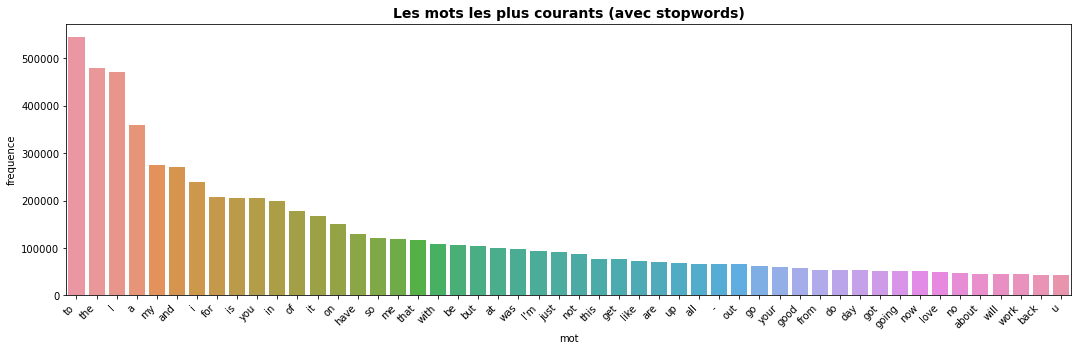

In [39]:
frequence(df, "tweet")

Nous pouvons voir que nous avons des mots très peu informatifs comme to, it, my, of, in etc. "I" a même plus de 900 000 occurrences.

Il est claire que nous allons utilisé les tweets avec le traitement complet.

Voyons du côté des tweet ayant subis le prépocessing.

#### Avec preprocessing

Nombre de mots 64851695
    mot  frequence
0   not     316604
1    go     152136
2   get     149409
3  user      92352
4  good      81466
5   day      77818
6  like      73317
7    no      66729
8  work      58963
9  want      58571


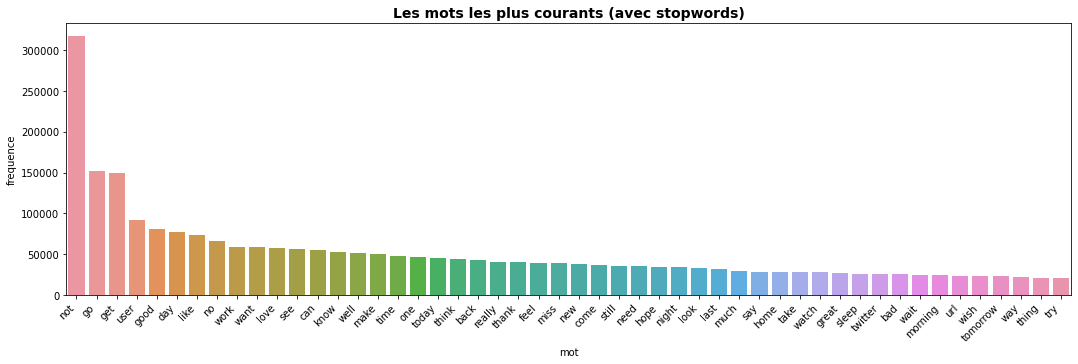

In [40]:
frequence(df, "tweet_traite")

# Export de la dataframe

In [41]:
df.to_csv("data/df_preprocessing_reduit_final.csv",index=False)

# Conclusion

Nous avons maintenant nettoyer nos tweets, ils sont prêt pour notre prochain algorithme de machine learning.

Nous aurions pu amméliorer notre traitement sur plusieurs points :

- **Corrigé l'orthographe** :
    - Nous avons essayé deux librairie pour cela, **Textblob** et **Pyspellchecker**. Mais le traitement s'est vu être très très long, voir même faisait planter le notebook.
    
- **En traduisant les tweet non anglais**:
    - Nous avions peur de la qualité que pourrait avoir une traduction, et du coup, donner un faux sens à la phrase et fausser ensuite notre résultat.
    
- **En supprimant les noms et prénoms**:
    - Mais nous n'avons pas trouvé de résultat convacant, en générale, la librairie ne fait que supprimer les mots avec la première lettre en majuscule.